In [1]:
import scipy
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import os
import seaborn as sns
import json

import warnings; warnings.simplefilter('ignore')

CM = 1/2.54  # centimeters in inches

clColorStr = 'Blues'
kColorStr = 'Oranges'
expColorStr = 'Purples'

kColors = getattr(cm, kColorStr)(np.linspace(0.3, 0.8, 4))
clColors = getattr(cm, clColorStr)(np.linspace(0.3, 0.8, 4))
expColors = getattr(cm, expColorStr)(np.linspace(0.3, 0.8, 4))

kColor = kColors[-2]
clColor = clColors[-1]
expColor = expColors[-1]

plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rcParams['lines.linewidth'] = 0.75
plt.rc('font', size=8)

def tauFunc(x, A, tau, b): 
    return A * np.exp(-x/tau) + b

def Ifunc(I, p1, p2, p3=1):
    p3 = 1 
    return p3/(1+np.exp(p1/p2)*I**(-1/(p2*np.log(10))))

def fit(xs, ys, func, p0):
    params, cv = scipy.optimize.curve_fit(func, xs, ys, p0)
    r2 =  1 - np.sum(np.square(ys - func(xs, params[0], params[1], params[2]))) / np.sum(np.square(ys - np.mean(ys)))
    return params, r2

def fitOpsinmodel(X, Y, Vs, xI, yI, tStimStart = 275, tStimEnd = 755):

    Iss = np.zeros(Vs.size)
    Ipeaks = np.zeros(Vs.size)
    tauOffs = np.zeros(Vs.size)
    tauOns = np.zeros(Vs.size)
    tauInacts = np.zeros(Vs.size)
    tauOff_R2s = np.zeros(Vs.size)
    tauOn_R2s = np.zeros(Vs.size)
    tauInact_R2s = np.zeros(Vs.size)

    xI, yI  = xI[~np.isnan(xI)], yI[~np.isnan(yI)]
    
    maxi = np.max(np.max(Y[~np.isnan(Y)]))

    fig, axs = plt.subplots(1,2, figsize = (10,3))
    colors = getattr(cm, 'Spectral')(np.linspace(0.1, 0.9, 7))
    for i, V in enumerate(Vs):
        x, y = X[i,:], Y[i,:]
        x, y  = x[~np.isnan(x)], y[~np.isnan(y)]
        
        axs[0].plot(x,y,color = colors[i], alpha = 0.2)
        
        i_peak = np.argmax(y)
        i_ss = np.where(x>tStimEnd)[0][0]
        i_on = np.where(x<tStimStart+0.1)[0][-1]
        Ipeaks[i] = y[i_peak]
        Iss[i] = y[i_ss]

        xOn, yOn = x[i_on:i_peak+1], y[i_on:i_peak+1] 
        if len(xOn)<4:
            print('V = ' + str(V) + ': too little points to accurately estimate tauOn')
            tauOns[i], tauOn_R2s[i] = np.nan, np.nan
        else:
            yOn = np.interp(np.arange(xOn[0], xOn[-1], 0.01),xOn,yOn)
            xOn = np.arange(xOn[0], xOn[-1], 0.01)-xOn[0]
            params, tauOn_R2s[i] = fit(xOn, yOn, tauFunc, (50, -1, maxi))
            A, tauOns[i], b = params
            axs[0].plot(x[i_on:i_peak+1], y[i_on:i_peak+1], '.', color = colors[i])
            print(x[i_on:i_peak+1].shape, tauFunc(xOn, A, tauOns[i], b).shape)
            axs[0].plot(xOn+x[i_on], tauFunc(xOn, A, tauOns[i], b), ':', color = colors[i], label = str(V)+ ' mV, Off, r2 = ' +str(np.round(tauOff_R2s[i],2)))
            
        xOff, yOff = x[i_ss:], y[i_ss:] 
        yOff = np.interp(np.arange(xOff[0], xOff[-1], 0.01),xOff,yOff)
        xOff = np.arange(xOff[0], xOff[-1], 0.01) - xOff[0]
        params, tauOff_R2s[i] = fit(xOff, yOff, tauFunc, (50, 100, maxi))
        A, tauOffs[i], b = params
        axs[0].plot(x[i_ss:], y[i_ss:], '.', color = colors[i])
        axs[0].plot(xOff+x[i_ss], tauFunc(xOff, A, tauOffs[i], b), color = colors[i], label = str(V)+ ' mV, Off, r2 = ' +str(np.round(tauOff_R2s[i],2)))
        
        xInact, yInact = x[i_peak:i_ss+1], y[i_peak: i_ss+1]
        yInact = np.interp(np.arange(xInact[0], xInact[-1], 0.01),xInact,yInact)
        xInact = np.arange(xInact[0], xInact[-1], 0.01)-xInact[0]
        params, tauInact_R2s[i] = fit(xInact, yInact, tauFunc, (50, 100, maxi))
        A, tauInacts[i], b = params
        axs[0].plot(x[i_peak:i_ss+1], y[i_peak: i_ss+1], '.', color = colors[i])
        axs[0].plot(xInact+x[i_peak], tauFunc(xInact, A, tauInacts[i], b), '--', color = colors[i], label = str(V)+ ' mV, Inact, r2 = ' +str(np.round(tauInact_R2s[i],2)))

    axs[0].set_ylim(0,)
    params, r2 = fit(xI, yI, Ifunc, (2.5,0.7, 1))
    p1, p2 , _ = params
    axs[1].scatter(xI, yI, color = 'black')
    axs[1].plot(np.logspace(-3,4,1000), Ifunc(np.logspace(-3,4,1000), p1, p2), label =('p1:', p1, 'p2:', p2, 'r2:', r2), color = 'black')
    axs[1].set_xscale('log')
    for i in range(2):axs[i].legend()
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1,3, figsize = (10,3))
    axs[0].scatter(Vs, Iss, label ='Iss', color = 'black')
    a_Iss,b_Iss = np.polyfit(Vs, Iss, 1)
    R2_Iss = 1 - np.sum(np.square(Iss - (a_Iss*Vs+b_Iss))) / np.sum(np.square(Iss - np.mean(Iss)))
    axs[0].plot(np.linspace(np.min(Vs), np.max(Vs), 100), np.linspace(np.min(Vs), np.max(Vs), 100)*a_Iss+b_Iss, '--', label = R2_Iss, color = 'black')

    axs[0].scatter(Vs, Ipeaks, label ='Ipeaks', color ='blue')
    a_Ipeaks, b_Ipeaks = np.polyfit(Vs, Ipeaks, 1)
    R2_Ipeaks = 1 - np.sum(np.square(Ipeaks - (a_Ipeaks*Vs+b_Ipeaks))) / np.sum(np.square(Ipeaks - np.mean(Ipeaks)))
    axs[0].plot(np.linspace(np.min(Vs), np.max(Vs), 100), np.linspace(np.min(Vs), np.max(Vs), 100)*a_Ipeaks+b_Ipeaks, '--', label = R2_Ipeaks, color = 'blue')

    axs[1].scatter(Vs, Iss/Ipeaks, label ='Iratio', color = 'black')
    axs[1].set_ylim(0,1)
    axs[2].scatter(Vs, tauInacts, label ='tauInact', color = 'black')
    axs[2].scatter(Vs, tauOffs, label ='tauOff', color = 'blue')
    if np.sum(np.isnan(tauOns)) ==0 : axs[2].scatter(Vs, tauOns, label ='tauOff', color = 'green')
    for i in range(3):axs[i].legend()
    plt.tight_layout()
    plt.show()
    return {'Iratio': np.mean(Iss/Ipeaks), 'tauOff': np.mean(tauOffs), 'tauInact': np.mean(tauInacts), 'tauOn': np.mean(tauOns), 'Oinf_p1': p1, 'Oinf_p2':p2}

V = 40.0: too little points to accurately estimate tauOn
V = 20.0: too little points to accurately estimate tauOn
V = 0.0: too little points to accurately estimate tauOn
V = -20.0: too little points to accurately estimate tauOn
V = -40.0: too little points to accurately estimate tauOn
V = -60.0: too little points to accurately estimate tauOn
V = -80.0: too little points to accurately estimate tauOn


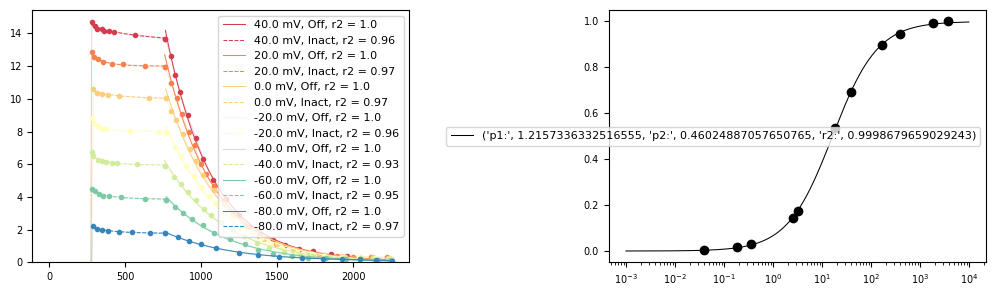

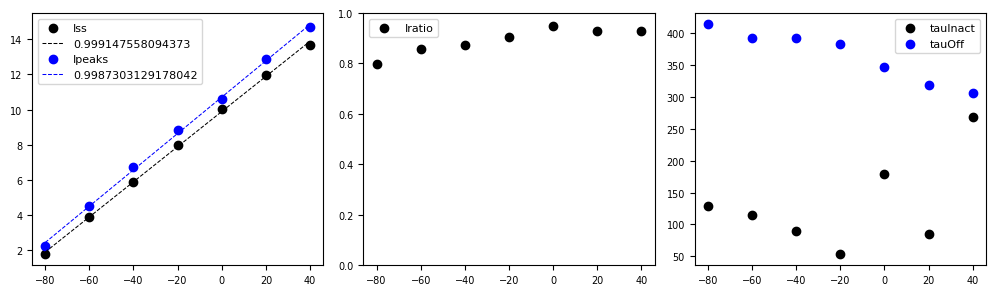

{'Iratio': 0.891594034761886, 'tauOff': 364.9703281115925, 'tauInact': 131.3676586586645, 'tauOn': nan, 'Oinf_p1': 1.2157336332516555, 'Oinf_p2': 0.46024887057650765}


In [2]:
#Experimental data preparation
tStimStart = 275
tStimEnd = 755

data = pd.read_csv('Data/WiChRExperimentalData.csv')
xI = data['I']
yI = data['iPeak']

X_col = [col for col in data.columns if 'X' in col]
Y_col = [col for col in data.columns if 'Y' in col]
Vs = np.array([col.split('V=')[-1].split('mV')[0] for col in X_col]).astype('float')
X = np.array(data[X_col]).T
Y = np.array(data[Y_col]).T

#fit wichr data to opsin model
params = fitOpsinmodel(X, Y, Vs, xI, yI, tStimStart = 275, tStimEnd = 755)
print(params)

In [3]:
#Run simulations
from Functions.setup import simParams
from Functions.utils import Dict
from Functions.Simulation import runSimulation

inputs = []

tStimStart = 275
tStimEnd = 755

Iratio = params['Iratio']
tauOn = 1
tauOff = params['tauOff']
tauInact = params['tauInact']
tauRecov = 5000
Oinf_p1 = params['Oinf_p1']
Oinf_p2 = params['Oinf_p2']

Is = np.logspace(-5, 2, 15)*1e3
Vclamp = np.arange(-80, 41, 40).astype(float)

Erev = -100

id = 0
for V in Vclamp:
    for I in Is:
        inputs.append(Dict(simParams().todict(inplace=False)))
        
        inputs[-1].stimopt.Estimparams.vClamp = True
        
        inputs[-1].cellsopt.opsin_options.opsinmech = 'K22OMs'
        

        inputs[-1].recordDict = {'v': ['allsec'], 
                                'ecl': ['somatic'], 'icl': ['somatic'], 'cli': ['somatic'], 'clo': ['somatic'],
                                'ek': ['somatic'],  'ik':  ['somatic'],  'ki': ['somatic'], 'ko':  ['somatic'],
                                'ena': [], 'ina': [], 'nai': [], 'nao': [],
                                'iopto': ['somatic'], 'gopto': ['somatic'], 'DAopto': [], 'Oopto': [],
                                'tauO': [], 'tauR': [], 'Rinf': [], 'Oinf': []}

        inputs[-1].saveDict = {'t': None, 'synapseInput': None, 'regionsDict': None, 'Iopto': None, 
                        'v': [], 'ecl': [], 'iopto': ['somatic'], 'gopto': [],
                        'tauO': [], 'tauR': [], 'Rinf': [], 'Oinf': []}

        inputs[-1].analysesopt.featuresDict = { }

        inputs[-1].cellsopt.opsin_options.Iratio = Iratio
        inputs[-1].cellsopt.opsin_options.tauOn = tauOn
        inputs[-1].cellsopt.opsin_options.tauOff = tauOff
        inputs[-1].cellsopt.opsin_options.tauInact = tauInact
        inputs[-1].cellsopt.opsin_options.tauRecov = tauRecov
        inputs[-1].cellsopt.opsin_options.Oinf_p1 = Oinf_p1
        inputs[-1].cellsopt.opsin_options.Oinf_p2 = Oinf_p2

        #chosen as to match experimental setup
        inputs[-1].cellsopt.opsin_options.Erev = Erev
        inputs[-1].cellsopt.ion_options.cextra0 =  {'cl':145,  'k': 1,    'na':110}  
        inputs[-1].cellsopt.ion_options.cintra0 =  {'cl':7,    'k': 110,   'na': 1} 
        inputs[-1].cellsopt.opsin_options.EvarFlag = 0
        
        inputs[-1].duration = 2500
        inputs[-1].stimopt.Ostimparams.dur = tStimEnd-tStimStart
        inputs[-1].stimopt.Ostimparams.delay = tStimStart
        inputs[-1].stimopt.Estimparams.dur = 2250
        inputs[-1].stimopt.Estimparams.delay = 100

        inputs[-1].returnResults = False

        inputs[-1].resultsFolder = 'Results/FitTest'
        
        inputs[-1].stimopt.Estimparams.amp = V
        inputs[-1].stimopt.Ostimparams.amp = I
        inputs[-1].id = id

        inputs[-1].analysesopt.featuresDict = {}
        id+=1

#import multiprocessing as mp
#import tqdm
#pool = mp.Pool(8)
#results = list(tqdm.tqdm(pool.imap(runSimulation, inputs), total=len(inputs)))

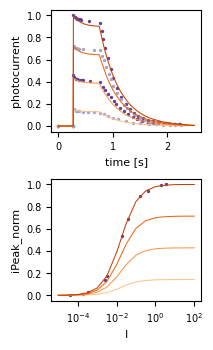

In [4]:
#compare model to experiments
df = None
t_continuous = None

folders = ['Results/FitTest']
           
for folder in folders:
    resultfiles = [x for x in os.listdir(folder) if x.endswith("results.json")]
    inputfiles = [x for x in os.listdir(folder) if x.endswith("input.json")]
    for i in range(len(resultfiles)):
        with open(folder + '/' + resultfiles[i]) as f: results = Dict(json.load(f))
        with open(folder + '/' + inputfiles[i]) as f: input = Dict(json.load(f)['settings'])
        newRow = {
            'model': 'fitTest',
            'I': float(input.stimopt.Ostimparams.amp),
            'V': float(input.stimopt.Estimparams.amp),
            'iOpto': [np.array(results.recordings.iopto[results.regionsDict['somatic'][0]])], 
            'iPeak': np.max(np.array(results.recordings.iopto[results.regionsDict['somatic'][0]])),
        }
        df = pd.DataFrame(newRow) if df is None else pd.concat([df, pd.DataFrame(newRow)])
    if t_continuous is None: t_continuous = np.array(results.t).astype(float)
df['I'] = df['I']*1e-3
Is = np.sort(df['I'].unique())
Imax = np.max(Is)

#plot comparison
fig, axs = plt.subplots(2,1, figsize = (5.5*CM, 9*CM))
df_ = df.loc[(df['I'] == Imax)]
imax = np.nanmax(np.array(df_['iOpto'].to_list()))
df['iPeak_norm'] = df['iPeak']/imax

for i, V in enumerate(Vclamp):
    df_select = df_.loc[(df_['V'] == V)]
    axs[0].plot(t_continuous.astype(float)*1e-3, np.array(df_select['iOpto'].to_list()).T/imax, label = V, color = kColors[i])

for i, V in enumerate(Vs): 
    if V % 40 == 0: axs[0].scatter(X[i,:]*1e-3, Y[i,:]/np.max(np.max(Y[~np.isnan(Y)])), color = expColors[expColors.shape[0]-i-1], s =2)
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('photocurrent')

sns.lineplot(df.dropna(), x='I', y='iPeak_norm', hue = 'V', ax = axs[1], palette = kColors, legend = False)
axs[1].scatter(xI*1e-3, yI, color = expColor, s= 2)
axs[1].set_xscale('log')
plt.tight_layout()
plt.savefig("OpsinFit.svg")
plt.show()